#### By Adam Thomson for URI Quantum Computing program

Based on qiskit tutorial https://learning.quantum.ibm.com/tutorial/grovers-algorithm 

In [19]:
# Built-in modules
import math

# Imports from Qiskit
from qiskit import QuantumCircuit, transpile
from qiskit.circuit.library import GroverOperator, MCMT, ZGate
from qiskit.visualization import plot_distribution, plot_histogram

# Imports from Qiskit Runtime
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_ibm_runtime import SamplerV2 as Sampler

from qiskit_aer import AerSimulator

sampler = AerSimulator()

In [12]:
# Setup base to bit mapping
BASE_MAP = {
    "A": "00",
    "G": "01",
    "C": "10",
    "T": "11",
}

In [13]:
def _convert_base_seq_to_marked_state(seq):
    marked_state = ""

    for bp in seq:
        marked_state += BASE_MAP[bp]
    
    return marked_state

def sequence_oracle(base_seqs):
    """Build a Grover oracle for multiple marked base sequences

    Here we assume all input sequences have the same number of bits

    Parameters:
        marked_states (str or list): Marked states of oracle

    Returns:
        QuantumCircuit: Quantum circuit representing Grover oracle
    """
    if not isinstance(base_seqs, list):
        base_seqs = [base_seqs]
   
    marked_states = [
        _convert_base_seq_to_marked_state(base_seq)
        for base_seq in base_seqs
    ]
    
    # Compute the number of qubits in circuit
    num_qubits = len(marked_states[0])

    qc = QuantumCircuit(num_qubits)
    # Mark each target state in the input list
    for target in marked_states:
        if len(target) != num_qubits:
            raise ValueError('All input sequences must be the same length')
        # Flip target bit-string to match Qiskit bit-ordering
        rev_target = target[::-1]
        # Find the indices of all the '0' elements in bit-string
        zero_inds = [ind for ind in range(num_qubits) if rev_target.startswith("0", ind)]
        # Add a multi-controlled Z-gate with pre- and post-applied X-gates (open-controls)
        # where the target bit-string has a '0' entry
        qc.x(zero_inds)
        qc.compose(MCMT(ZGate(), num_qubits - 1, 1), inplace=True)
        qc.x(zero_inds)
    return qc

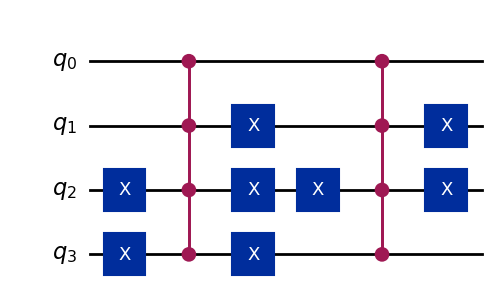

In [14]:
marked_states = ["AT", "CG"]

oracle = sequence_oracle(marked_states)
oracle.draw(output="mpl", style="iqp")

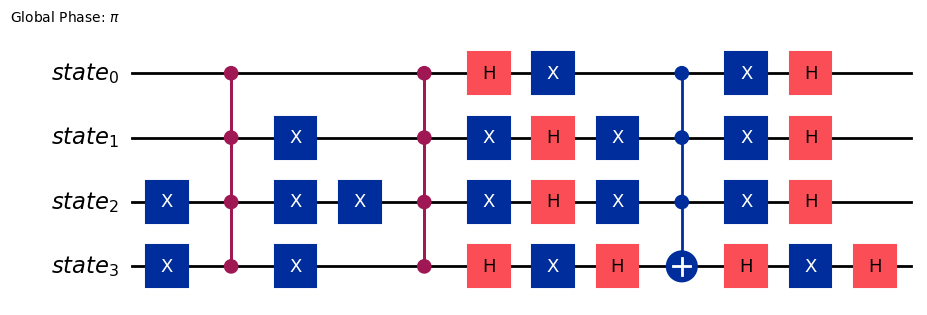

In [15]:
grover_op = GroverOperator(oracle)
grover_op.decompose().draw(output="mpl", style="iqp")

In [16]:
optimal_num_iterations = math.floor(
    math.pi / (4 * math.asin(math.sqrt(len(marked_states) / 2**grover_op.num_qubits)))
)

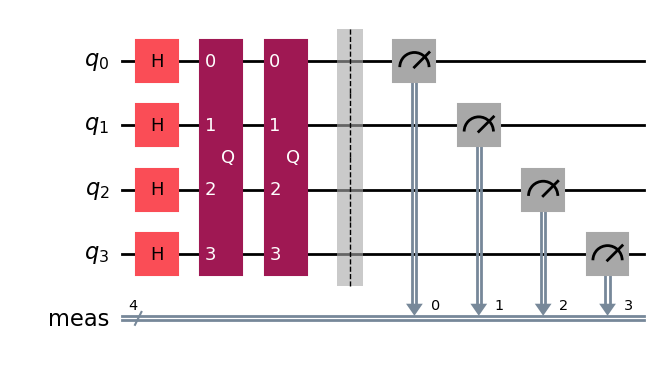

In [17]:
qc = QuantumCircuit(grover_op.num_qubits)
# Create even superposition of all basis states
qc.h(range(grover_op.num_qubits))
# Apply Grover operator the optimal number of times
qc.compose(grover_op.power(optimal_num_iterations), inplace=True)
# Measure all qubits
qc.measure_all()
qc.draw(output="mpl", style="iqp")

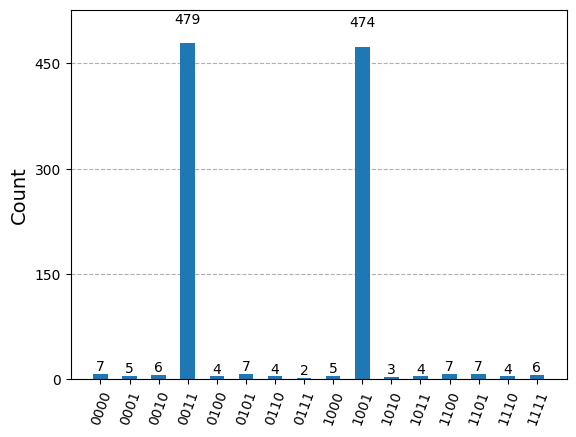

In [21]:
# Run on local simulator to examine results
transp_circuit = transpile(qc, sampler)
results = sampler.run(transp_circuit).result()
counts = results.get_counts()
plot_histogram(counts)

Our results match our expectation! The bitstring that map to "AT" (0011) and "CG" (1001) are measured with much higher probability than any other possible string. Now let's check the results on real hardware

In [ ]:
# Run on real hardware
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

# select the backend with the fewest number of jobs in the queue
service = QiskitRuntimeService(channel="ibm_quantum")
backend = service.least_busy(operational=True, simulator=False)
backend.name
target = backend.target

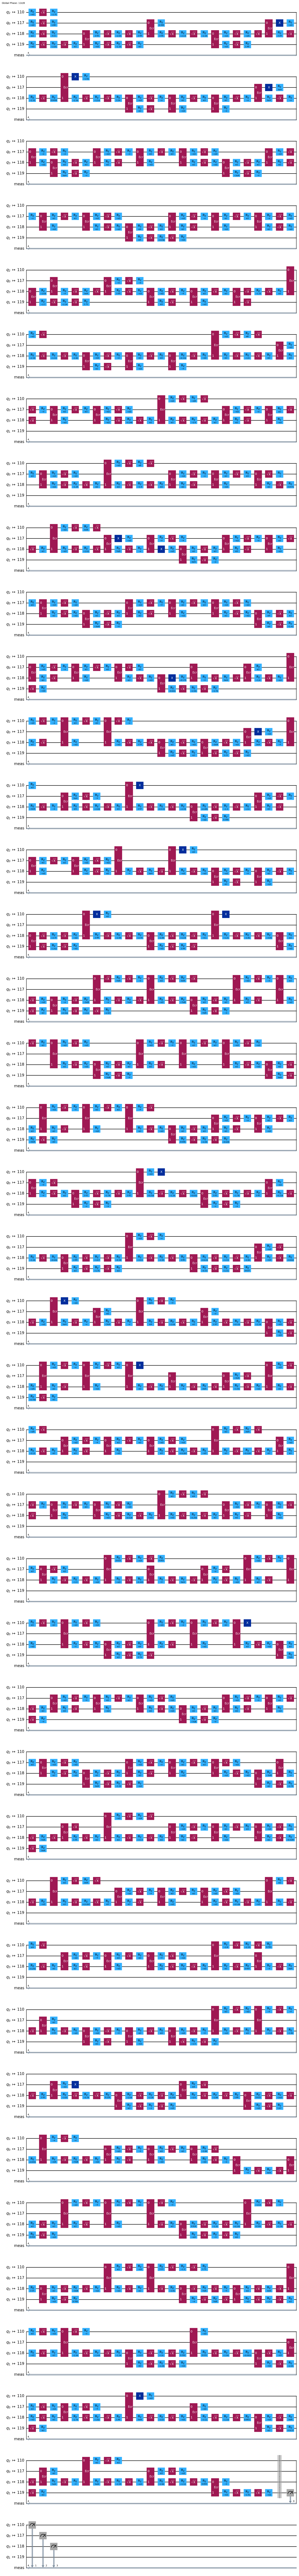

In [28]:
pm = generate_preset_pass_manager(target=target, optimization_level=3)

circuit_isa = pm.run(qc)
circuit_isa.draw(output="mpl", idle_wires=False, style="iqp")

In [29]:
# Run on real hardware to check results
real_sampler = Sampler(mode=backend)
real_sampler.options.default_shots = 1_000
real_result = real_sampler.run([circuit_isa]).result()
real_dist = real_result[0].data.meas.get_counts()

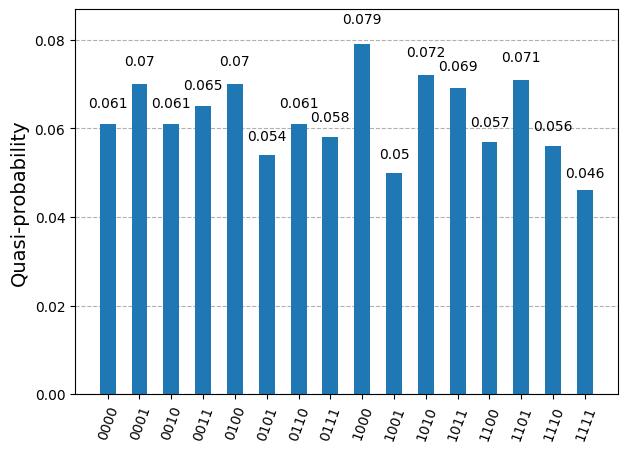

In [30]:
plot_distribution(real_dist)

When running on a real device, we see that the result we get is almost entirely random! This is due to error build up in the quantum devices over time. Even though there are only 4 qubits in the circuit, the circuit is long enough that the ideal state is completely lost by the time of measurement.

It is clear that quantum hardware advances are required before quantum computers are ready for true bioinformatic research!